## Solution - I

__Problem Statement -__ The Bank Indessa has not done well in the last 3 quarters. Their NPAs (Non Performing Assets) have reached all time high. It is starting to lose the confidence of its investors. As a result, it’s stock has fallen by 20% in the previous quarter alone.

After careful analysis, it was found that the majority of NPA was contributed by loan defaulters. With the messy data collected over all the years, this bank has decided to use machine learning to figure out a way to find these defaulters and devise a plan to reduce them.

This bank uses a pool of investors to sanction their loans. For example: If any customer has applied for a loan of $20000, along with the bank, the investors perform due diligence on the requested loan application. Keep this in mind while understanding data.

In this challenge, you will help this bank by predicting the probability that a member will default

---
__Evaluation -__ AUC ROC matrics




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## A) import Libraries and Dataset

In [2]:
# data manipulation library
import pandas as pd  
import numpy as np

# data visualization library
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
%matplotlib inline

# modeling library
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score,\
                            roc_auc_score, roc_curve, auc

# time based and warnings library
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', 500)

In [3]:
# load the dataset
dataset_train = pd.read_csv("drive/MyDrive/dataset_mumbai/train_indessa.csv")
dataset_test = pd.read_csv("drive/MyDrive/dataset_mumbai/test_indessa.csv")

In [4]:
# copy the original dataset for future references
data_train = dataset_train.copy()
data_test = dataset_test.copy()

In [5]:
data_train.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,9 years,OWN,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,RENT,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0


In [6]:
data_test.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,11937648,14000,14000,14000.0,60 months,BAT4711174,16.24,C,C5,Data Analyst,4 years,RENT,73500.0,Source Verified,n,NaN,credit_card,wrap it up,450xx,OH,28.65,1.0,1.0,20.0,NaN,16.0,0.0,29828,65.3,53.0,f,3915.61,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,104th week,0.0,0.0,85230.0,45700.0
1,38983318,16000,16000,16000.0,60 months,BAT4318899,9.49,B,B2,Senior Database Administrator,5 years,MORTGAGE,105000.0,Source Verified,n,NaN,major_purchase,Major purchase,275xx,NC,31.19,0.0,0.0,NaN,NaN,8.0,0.0,4161,19.4,63.0,w,1495.06,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,57th week,0.0,0.0,444991.0,21400.0
2,27999917,11050,11050,11050.0,60 months,BAT446479,15.61,D,D1,Customer service representative,10+ years,RENT,62300.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,672xx,KS,21.73,1.0,0.0,23.0,115.0,11.0,1.0,12064,74.0,20.0,w,2096.21,0.0,0.0,0.0,0.0,26.0,INDIVIDUAL,NaN,70th week,0.0,0.0,105737.0,16300.0
3,61514932,35000,35000,34700.0,60 months,BAT4664105,12.69,C,C2,ACCT OFFICER,10+ years,OWN,150000.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,961xx,CA,17.27,0.0,0.0,NaN,NaN,21.0,0.0,32549,45.0,26.0,f,1756.31,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,22th week,0.0,0.0,287022.0,72400.0
4,59622821,6500,6500,6500.0,36 months,,6.89,A,A3,Paralegal,5 years,MORTGAGE,52000.0,Not Verified,n,NaN,major_purchase,Major purchase,707xx,LA,20.19,0.0,0.0,NaN,NaN,16.0,0.0,5133,19.2,36.0,w,172.21,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,22th week,0.0,0.0,234278.0,26700.0


## B) Basic EDA

### B-1) EDA I

In [7]:
# dimenssion of data
print('(1) Training data : {train} \n(2) Testing data  : {test}'.format(train = data_train.shape, test = data_test.shape))

(1) Training data : (532428, 45) 
(2) Testing data  : (354951, 44)


In [8]:
# information about the data and the datatypes of each respective attribute (Training data)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532428 entries, 0 to 532427
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    532428 non-null  int64  
 1   loan_amnt                    532428 non-null  int64  
 2   funded_amnt                  532428 non-null  int64  
 3   funded_amnt_inv              532428 non-null  float64
 4   term                         532428 non-null  object 
 5   batch_enrolled               447279 non-null  object 
 6   int_rate                     532428 non-null  float64
 7   grade                        532428 non-null  object 
 8   sub_grade                    532428 non-null  object 
 9   emp_title                    501595 non-null  object 
 10  emp_length                   505537 non-null  object 
 11  home_ownership               532428 non-null  object 
 12  annual_inc                   532425 non-null  float64
 13 

In [9]:
# information about the data and the datatypes of each respective attribute (Testing data)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354951 entries, 0 to 354950
Data columns (total 44 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    354951 non-null  int64  
 1   loan_amnt                    354951 non-null  int64  
 2   funded_amnt                  354951 non-null  int64  
 3   funded_amnt_inv              354951 non-null  float64
 4   term                         354951 non-null  object 
 5   batch_enrolled               309352 non-null  object 
 6   int_rate                     354951 non-null  float64
 7   grade                        354951 non-null  object 
 8   sub_grade                    354951 non-null  object 
 9   emp_title                    334322 non-null  object 
 10  emp_length                   337017 non-null  object 
 11  home_ownership               354951 non-null  object 
 12  annual_inc                   354950 non-null  float64
 13 

__Training data__
- Data dimenssion = (532428, 45) [records, features]
- Datatypes = float64(23), int64(4), object(18)

__Testing data__
- (354951, 44) [records, features]
- Datatypers = float64(22), int64(4), object(18)

In [10]:
# statistical summary (training)
pd.set_option("display.float_format", "{:.2f}".format)
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
member_id,532428.00,35005472.35,24121476.52,70473.00,10866882.50,37095895.00,58489200.75,73544841.00
loan_amnt,532428.00,14757.60,8434.42,500.00,8000.00,13000.00,20000.00,35000.00
funded_amnt,532428.00,14744.27,8429.14,500.00,8000.00,13000.00,20000.00,35000.00
funded_amnt_inv,532428.00,14704.93,8441.29,0.00,8000.00,13000.00,20000.00,35000.00
int_rate,532428.00,13.24,4.38,5.32,9.99,12.99,16.20,28.99
annual_inc,532425.00,75029.84,65199.85,1200.00,45000.00,65000.00,90000.00,9500000.00
dti,532428.00,18.14,8.37,0.00,11.93,17.65,23.95,672.52
delinq_2yrs,532412.00,0.31,0.86,0.00,0.00,0.00,0.00,30.00
inq_last_6mths,532412.00,0.69,1.00,0.00,0.00,0.00,1.00,31.00
mths_since_last_delinq,259874.00,34.06,21.88,0.00,15.00,31.00,50.00,180.00


In [11]:
# statistical summary (testing)
pd.set_option("display.float_format", "{:.2f}".format)
data_test.describe().T

,count,mean,std,min,25%,50%,75%,max
member_id,354951.00,34996353.50,24101199.69,70626.00,10889411.00,37086503.00,58448923.00,73544827.00
loan_amnt,354951.00,14751.77,8437.02,500.00,8000.00,13000.00,20000.00,35000.00
funded_amnt,354951.00,14738.29,8431.05,500.00,8000.00,13000.00,20000.00,35000.00
funded_amnt_inv,354951.00,14698.77,8443.34,0.00,8000.00,13000.00,20000.00,35000.00
int_rate,354951.00,13.25,4.39,5.32,9.99,12.99,16.20,28.99
annual_inc,354950.00,75024.20,63938.70,0.00,45000.00,65000.00,90000.00,9000000.00
dti,354951.00,18.18,25.17,0.00,11.89,17.65,23.94,9999.00
delinq_2yrs,354938.00,0.31,0.87,0.00,0.00,0.00,0.00,39.00
inq_last_6mths,354938.00,0.69,1.00,0.00,0.00,0.00,1.00,33.00
mths_since_last_delinq,173193.00,34.08,21.89,0.00,15.00,31.00,50.00,188.00


In [12]:
# finding the linear relationship among the variables
corr_data_train = data_train.corr()
corr_data_test = data_test.corr()

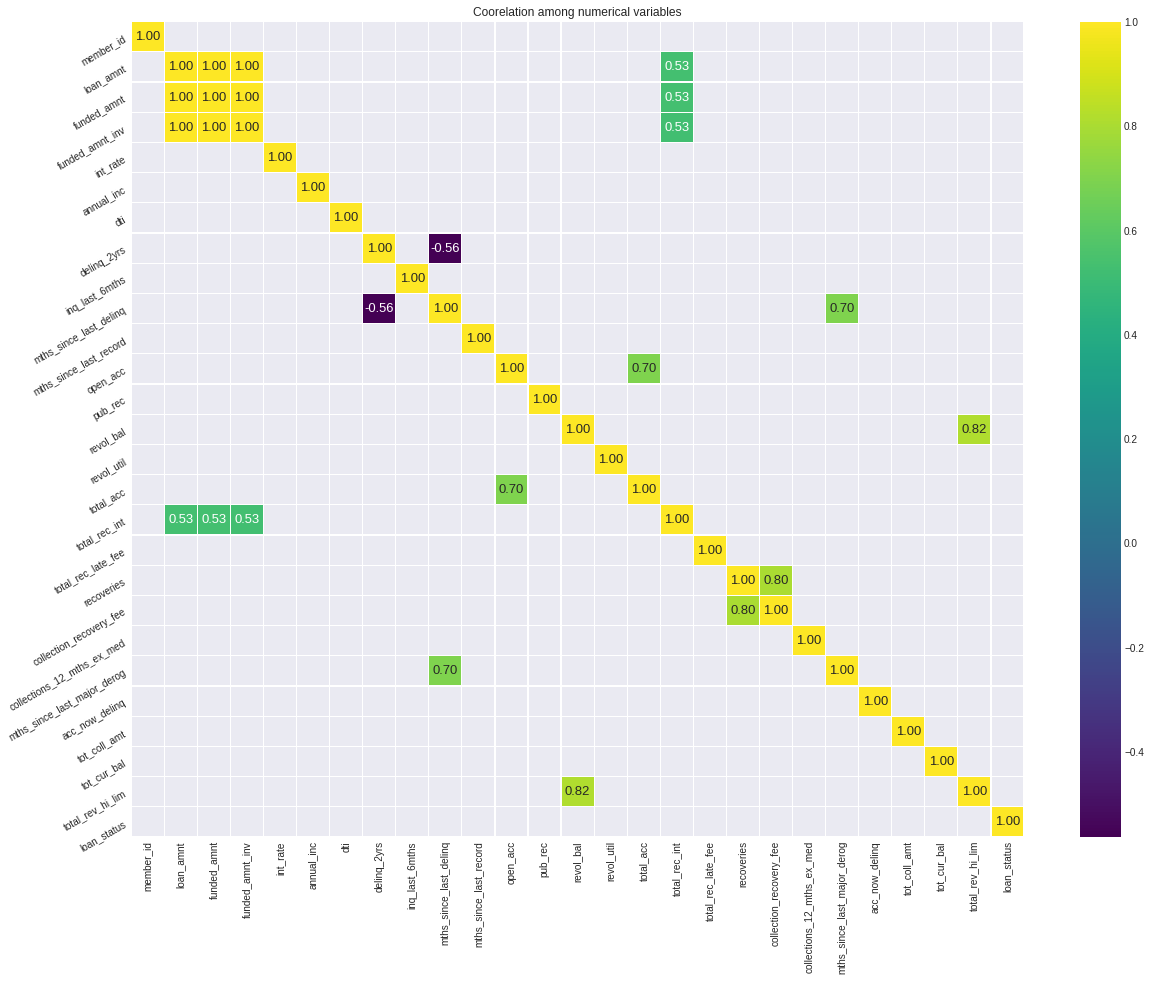

In [13]:
# Feature to feature relationship
plt.figure(figsize=(20, 15))
plt.title('Coorelation among numerical variables')
ax = sns.heatmap(corr_data_train[(corr_data_train >= 0.5) | (corr_data_train <= -0.5)], fmt = '.2f', cmap='viridis', annot = True,
                 linewidths = 0.2, annot_kws={"size": 13})
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 30)
plt.show()

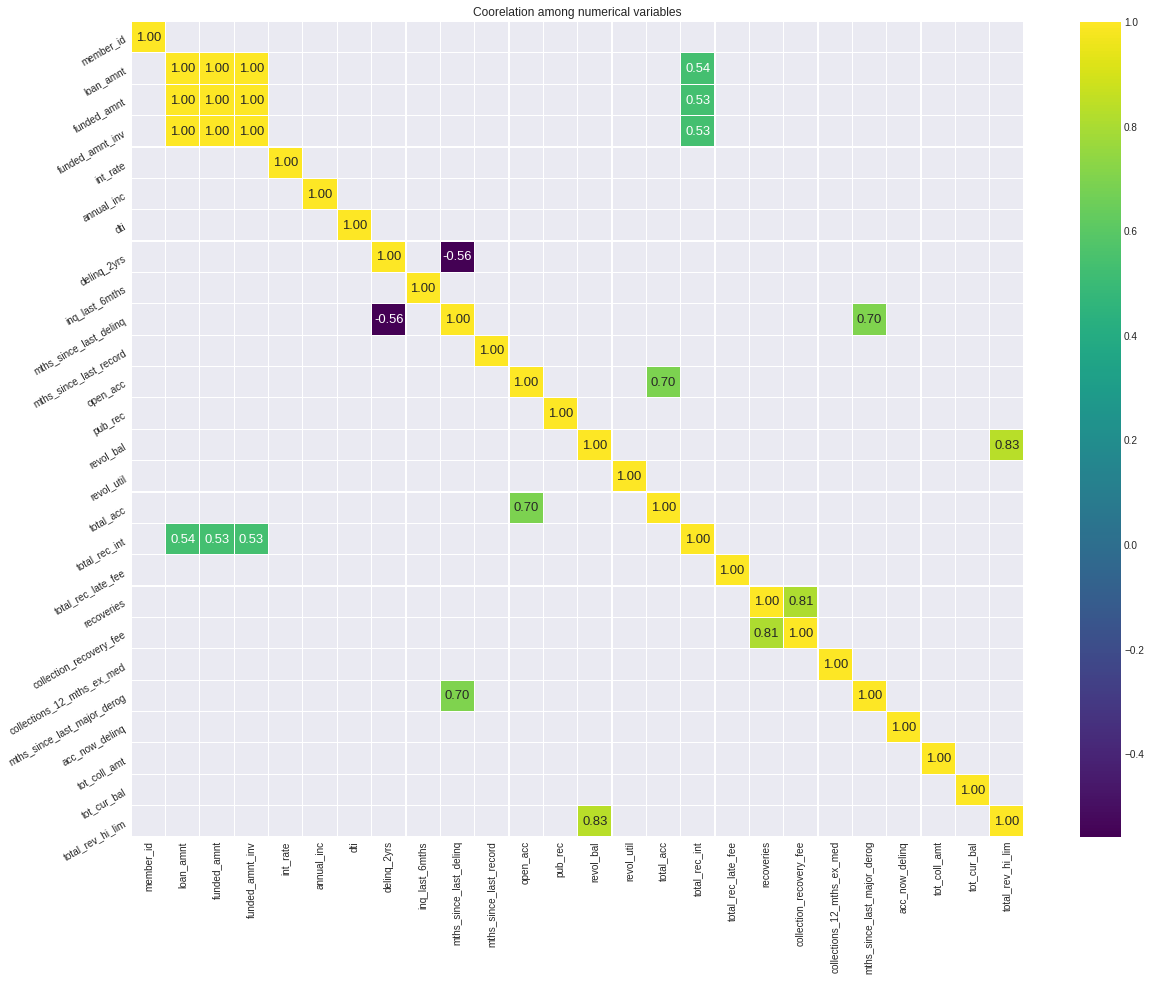

In [14]:
# Feature to feature relationship
plt.figure(figsize=(20, 15))
plt.title('Coorelation among numerical variables')
ax = sns.heatmap(corr_data_test[(corr_data_test >= 0.5) | (corr_data_test <= -0.5)], fmt = '.2f', cmap='viridis', annot = True,
                 linewidths = 0.2, annot_kws={"size": 13})
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 30)
plt.show()

- Training and testing data has similar corrleaton bound up, setting up threshold 0.5 (+/-) for checking the linear relatonship beteen variables (numeric)

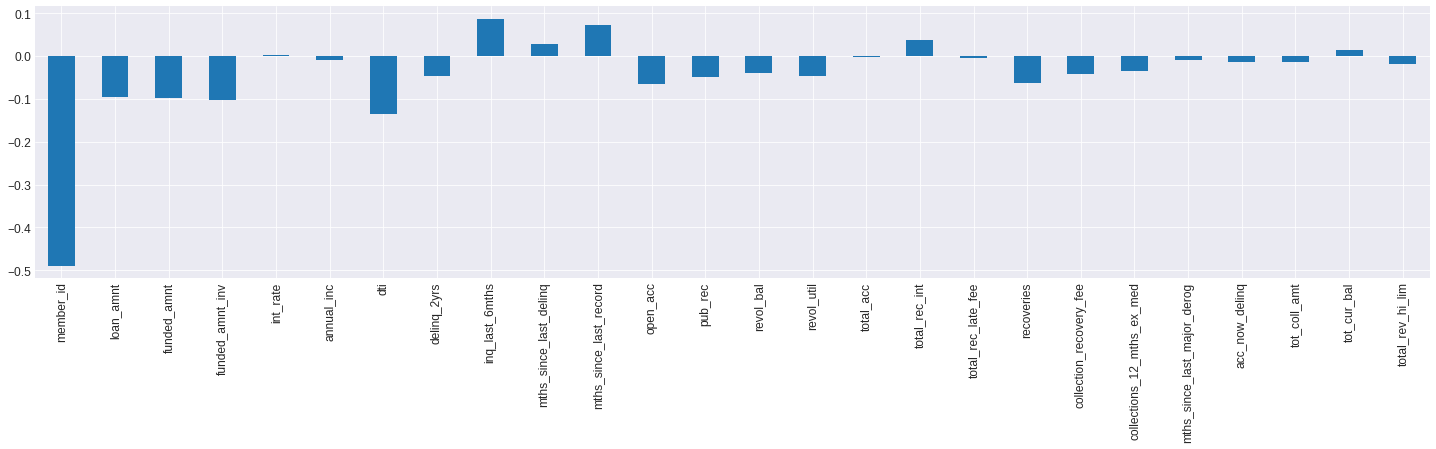

In [15]:
# feature correlation with target attribute (0 and 1)
var_1 = data_train.iloc[:, data_train.columns != 'loan_status']
ax = var_1.corrwith(data_train.loan_status).plot.bar(figsize = (25, 5), fontsize=12, grid=True)

- With respect to the target variable "loan_status", which feature impacting so far, we can analyzed.
- member_id is more contributing (-ve)
- inq_last_six_month and mths_since_last_record are contributing (+ve)

In [16]:
# To get the count of unique values and the list with number of unique values
'''
1) Differentiate the categorical features and numerical features with target attribute
2) Check all the available unique values that are present in the dataset columns
3) Datatypes available: float64, int64, object
'''

# <--- Grouping the columns for data analysis --->
# Define target attribute
target_col = data_train[['loan_status']]

# Define categorical and numerical attributes
categorical_col = data_train.select_dtypes(include = ['object'])
numerical_col = data_train.select_dtypes(include = ['float64', 'int64'])

# <--- Uniqueness for each of the features --->
# List to store names of all categorical and numerical features seperately
categorical_col_name = []
numerical_col_name = []

cnt_a = 0 
cnt_b = 0

print('<======= Categorical features with total unique categories =======>\n')
for column in data_train.columns:
    if data_train[column].dtype == object and len(data_train[column].unique()):
        categorical_col_name.append(column)
        cnt_a += 1
        print(f"{cnt_a}) {column} : {data_train[column].nunique()}")
        print("------------------------------------")
        print(f"{data_train[column].value_counts()}")
        print("====================================\n\n")

print('\n<======= Numerical features with total unique occurances =======>\n')
for column in data_train.columns:
    if (data_train[column].dtype == 'int64' or data_train[column].dtype == 'float64') and len(data_train[column].unique()):
        numerical_col_name.append(column)
        cnt_b += 1
        print(f"{cnt_b}) {column} : {data_train[column].nunique()}")
        print("------------------------------------")
        print(f"{data_train[column].value_counts()}")
        print("====================================\n\n")

<======= Categorical features with total unique categories =======>

1) term : 2
------------------------------------
36 months    372793
60 months    159635
Name: term, dtype: int64


2) batch_enrolled : 104
------------------------------------
              106079
BAT2252229     18791
BAT3873588     17839
BAT2803411     17111
BAT2078974     14859
               ...  
BAT4347689        30
BAT4884699        29
BAT5869156        26
BAT5077496        18
BAT2331079        13
Name: batch_enrolled, Length: 104, dtype: int64


3) grade : 7
------------------------------------
B    152713
C    147499
A     89107
D     83567
E     42495
F     13826
G      3221
Name: grade, dtype: int64


4) sub_grade : 35
------------------------------------
B3    33844
B4    33198
C1    31975
C2    31356
C3    30080
B2    29390
B5    29313
C4    29103
A5    27016
B1    26968
C5    24985
D1    21712
A4    20823
D2    17991
D3    15771
D4    15226
A3    14082
A1    13653
A2    13533
D5    12867
E1    10928
E2  

### B-2) EDA II

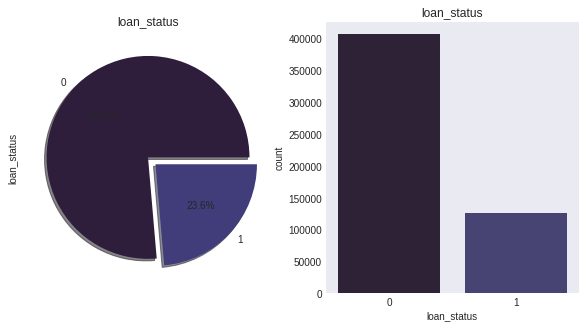

In [17]:
# target variable 
f,ax=plt.subplots(1,2,figsize=(10,5))
cmap_s = sns.color_palette("mako")
data_train['loan_status'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',colors = cmap_s,ax=ax[0],shadow=True)
ax[0].set_title('loan_status')
sns.countplot('loan_status', data=data_train,palette=cmap_s,ax=ax[1])
ax[1].set_title('loan_status')
plt.show()

- Data is imbalanced, preferably target feature __loan_status__.
- Majority data belongs to load_status = 0 __(76.4%)__ and minority data belongs to loan_status = 1 __(23.6%)__

__Note:__ Due to short time span, I have drop few methods and techniques.
1) Univariate + Bivariate analysis 
2) Outlier 

## C) Data Preprocessing

### C-1) Missing values findings

In [18]:
# checkc with NaN
count_nan_in_training = data_train.isnull().sum().sum()
print('Count of NaN: ' + str(count_nan_in_training))
print('NaN occurrences in Columns:')
print(data_train.isnull().sum(axis = 0))

Count of NaN: 2380715
NaN occurrences in Columns:
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
batch_enrolled                  85149
int_rate                            0
grade                               0
sub_grade                           0
emp_title                       30833
emp_length                      26891
home_ownership                      0
annual_inc                          3
verification_status                 0
pymnt_plan                          0
desc                           456829
purpose                             0
title                              90
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        16
inq_last_6mths                     16
mths_since_last_delinq         272554
mths_since_last_record         450305


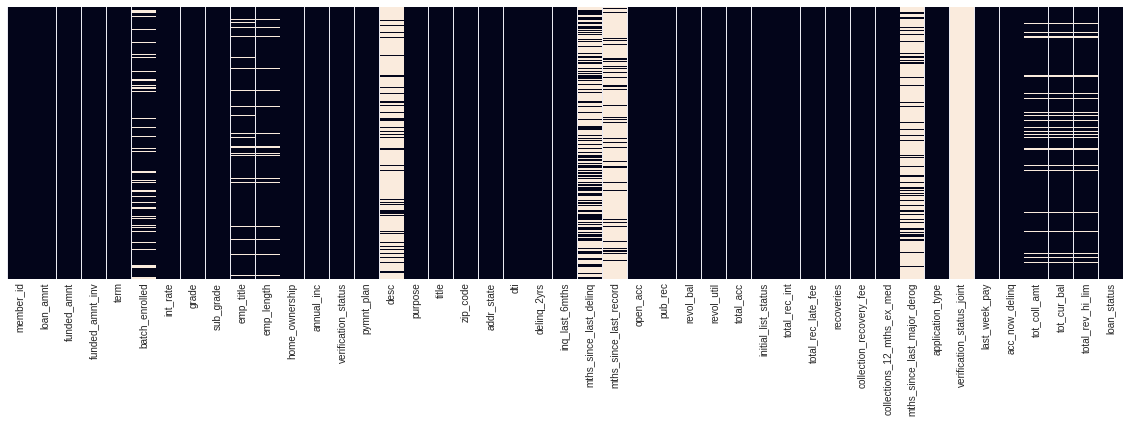

In [19]:
plt.figure(figsize=(20,5))
sns.heatmap(data_train.isnull(), yticklabels=False, cbar=False)

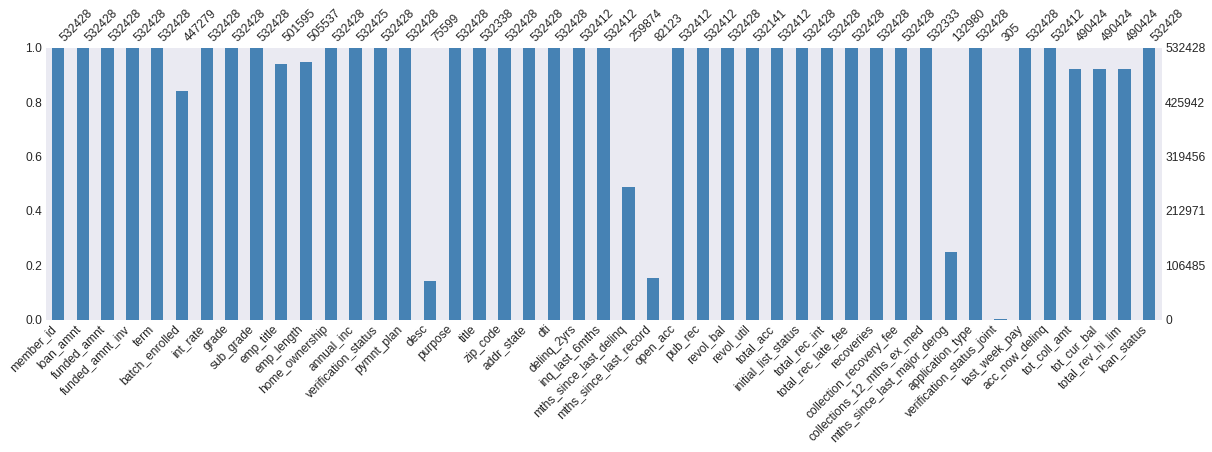

In [20]:
import missingno as msno
msno.bar(data_train, figsize=(20, 5), fontsize=12, color='steelblue')

- Missing values are quite high, average and low in few of the features.
- Let's calcuate the % from top missing values towards low

In [21]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).sort_values(['Percent'], ascending=[False])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [22]:
missing_data(data_train)

,verification_status_joint,desc,mths_since_last_record,mths_since_last_major_derog,mths_since_last_delinq,batch_enrolled,total_rev_hi_lim,tot_cur_bal,tot_coll_amt,emp_title,emp_length,revol_util,collections_12_mths_ex_med,title,open_acc,pub_rec,delinq_2yrs,inq_last_6mths,acc_now_delinq,total_acc,annual_inc,recoveries,total_rec_late_fee,total_rec_int,collection_recovery_fee,initial_list_status,application_type,last_week_pay,member_id,revol_bal,loan_amnt,dti,addr_state,zip_code,purpose,pymnt_plan,verification_status,home_ownership,sub_grade,grade,int_rate,term,funded_amnt_inv,funded_amnt,loan_status
Total,532123,456829,450305,399448,272554,85149,42004,42004,42004,30833,26891,287,95,90,16,16,16,16,16,16,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,99.94,85.80,84.58,75.02,51.19,15.99,7.89,7.89,7.89,5.79,5.05,0.05,0.02,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Types,int64,int64,int64,float64,object,object,float64,object,object,object,object,object,float64,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64,int64


In [23]:
missing_data(data_test)

,verification_status_joint,desc,mths_since_last_record,mths_since_last_major_derog,mths_since_last_delinq,batch_enrolled,total_rev_hi_lim,tot_coll_amt,tot_cur_bal,emp_title,emp_length,revol_util,title,collections_12_mths_ex_med,acc_now_delinq,delinq_2yrs,total_acc,pub_rec,open_acc,inq_last_6mths,annual_inc,dti,recoveries,funded_amnt,funded_amnt_inv,term,last_week_pay,int_rate,application_type,grade,sub_grade,collection_recovery_fee,total_rec_late_fee,addr_state,total_rec_int,initial_list_status,home_ownership,revol_bal,verification_status,pymnt_plan,purpose,zip_code,loan_amnt,member_id
Total,354745,304770,300021,266228,181758,45599,28272,28272,28272,20629,17934,215,62,50,13,13,13,13,13,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,99.94,85.86,84.52,75.00,51.21,12.85,7.97,7.97,7.97,5.81,5.05,0.06,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Types,int64,int64,int64,float64,object,object,float64,object,object,object,object,object,float64,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,object,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64


- From training and testing set, same missing value percentage observed.
- Major missing values features are verification_status_joint __(99.9%)__,	desc __(85.5%)__,	mths_since_last_record __(84.5)__, mths_since_last_major_derog __(75.0%)__,	mths_since_last_delinq __(51.1%)__, batch_enrolled (15.9%), total_rev_hi_lim (7.8%),	tot_coll_amt (7.8%),	tot_cur_bal (7.8%),	emp_title (5.7%),	emp_length (5.0%), revol_util (0.05%), title (0.02%),	collections_12_mths_ex_med (0.01%)

**Missing value imputaion on Training dataset**

- Numerical features = 'collections_12_mths_ex_med', 'total_rev_hi_lim'
- Categorical features = 'batch_enrolled', 'tot_cur_bal', 'tot_coll_amt', 'emp_title', 'emp_length', 'revol_util', 'title'

In [24]:
def impute_nan(df, variable, median):
    df[variable + "_median"] = df[variable].fillna(median)

In [25]:
# numeric variables and will be imputed by median
median1 = numerical_col.collections_12_mths_ex_med.median()
median2 = numerical_col.total_rev_hi_lim.median()
print(median1, median2)

impute_nan(data_train,'collections_12_mths_ex_med', median1)
impute_nan(data_train,'total_rev_hi_lim', median2)

0.0 23700.0


In [26]:
# checking the standard deviations after imputaion with median
print(data_train['collections_12_mths_ex_med'].std())
print(data_train['collections_12_mths_ex_med_median'].std())

print(data_train['total_rev_hi_lim'].std())
print(data_train['total_rev_hi_lim_median'].std())

0.13300517521951655
0.13299344588945475
38053.0353120354
36590.977154522945


- After the imputation with meadian, we observed that the deviations is not too large for "collections_12_mths_ex_med", But for "total_rev_hi_lim" it is comparably quite vary.  

In [27]:
# categorical fratures with most frequent values
print(categorical_col['batch_enrolled'].value_counts().index[0])
print(data_train['tot_cur_bal'].value_counts().index[0])
print(data_train['tot_coll_amt'].value_counts().index[0])
print(categorical_col['emp_title'].value_counts().index[0])
print(categorical_col['emp_length'].value_counts().index[0])
print(data_train['revol_util'].value_counts().index[0])
print(categorical_col['title'].value_counts().index[0])

 
0.0
0.0
Teacher
10+ years
0.0
Debt consolidation


In [28]:
# replacing blank space with "BAT_NA"
print(data_train['batch_enrolled'].value_counts().index[0])
data_train['batch_enrolled'] = data_train['batch_enrolled'].replace([' '],'BAT_NA')
print(data_train['batch_enrolled'].value_counts().index[0])

 
BAT_NA


In [29]:
# categorical variables and will be imputed by mode
to_impute_by_mode =  data_train.loc[:, ['batch_enrolled', 'tot_cur_bal', 'tot_coll_amt', 'emp_title', 'emp_length', 'revol_util', 'title']]
for var in to_impute_by_mode.columns:
    data_train[var].fillna(data_train[var].mode()[0], inplace = True)

In [30]:
# Remove NaN form training dataset

# drop features (Nan > 50%)
data_train.drop(['verification_status_joint', 'desc', 'mths_since_last_record', 'mths_since_last_major_derog', 
                  'mths_since_last_delinq'], axis=1, inplace=True)

# drop old features (filled with imputation and create new features)
data_train.drop(['collections_12_mths_ex_med', 'total_rev_hi_lim'], axis=1, inplace=True)

# drop remaning NaN
data_train.dropna(inplace=True)
data_train.reset_index()

count_nan_in_training = data_train.isnull().sum().sum()
print('Count of NaN: ' + str(count_nan_in_training))
print('NaN occurrences in Columns:')
print(data_train.isnull().sum(axis = 0))

Count of NaN: 0
NaN occurrences in Columns:
member_id                            0
loan_amnt                            0
funded_amnt                          0
funded_amnt_inv                      0
term                                 0
batch_enrolled                       0
int_rate                             0
grade                                0
sub_grade                            0
emp_title                            0
emp_length                           0
home_ownership                       0
annual_inc                           0
verification_status                  0
pymnt_plan                           0
purpose                              0
title                                0
zip_code                             0
addr_state                           0
dti                                  0
delinq_2yrs                          0
inq_last_6mths                       0
open_acc                             0
pub_rec                              0
revol_bal           

In [31]:
data_train.head(3)

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,application_type,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,loan_status,collections_12_mths_ex_med_median,total_rev_hi_lim_median
0,58189336,14350,14350,14350.00,36 months,BAT_NA,19.19,E,E3,clerk,9 years,OWN,28700.00,Source Verified,n,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.00,1.00,14.00,1.00,22515.00,73.10,28.00,f,1173.84,0.00,0.00,0.00,INDIVIDUAL,26th week,0.00,0.00,28699.00,0,0.00,30800.00
1,70011223,4800,4800,4800.00,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.00,Source Verified,n,home_improvement,Home improvement,209xx,MD,3.64,0.00,1.00,6.00,0.00,7624.00,23.20,13.00,w,83.95,0.00,0.00,0.00,INDIVIDUAL,9th week,0.00,0.00,9974.00,0,0.00,32900.00
2,70255675,10000,10000,10000.00,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.00,Not Verified,n,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.00,0.00,5.00,0.00,10877.00,31.20,19.00,w,56.47,0.00,0.00,0.00,INDIVIDUAL,9th week,0.00,65.00,38295.00,0,0.00,34900.00


__Missing value imputaion on Testing dataset__

- Numerical features = 'collections_12_mths_ex_med', 'total_rev_hi_lim'
- Categorical features = 'batch_enrolled', 'tot_cur_bal', 'tot_coll_amt', 'emp_title', 'emp_length', 'revol_util', 'title'

In [32]:
def impute_nan(df, variable, median):
    df[variable + "_median"] = df[variable].fillna(median)

In [33]:
# numeric variables and will be imputed by median
median1 = data_test.collections_12_mths_ex_med.median()
median2 = data_test.total_rev_hi_lim.median()
print(median1, median2)

impute_nan(data_test,'collections_12_mths_ex_med', median1)
impute_nan(data_test,'total_rev_hi_lim', median2)

0.0 23700.0


In [34]:
# checking the standard deviations after imputaion with median
print(data_test['collections_12_mths_ex_med'].std())
print(data_test['collections_12_mths_ex_med_median'].std())

print(data_test['total_rev_hi_lim'].std())
print(data_test['total_rev_hi_lim_median'].std())

0.13594978536198193
0.13594031866221742
36649.6913404494
35232.44331036353


In [35]:
print(data_test['batch_enrolled'].value_counts().index[0])
print(data_test['tot_cur_bal'].value_counts().index[0])
print(data_test['tot_coll_amt'].value_counts().index[0])
print(data_test['emp_title'].value_counts().index[0])
print(data_test['emp_length'].value_counts().index[0])
print(data_test['revol_util'].value_counts().index[0])
print(data_test['title'].value_counts().index[0])

 
0.0
0.0
Teacher
10+ years
0.0
Debt consolidation


In [36]:
# replacing blank space with "BAT_NA"
print(data_test['batch_enrolled'].value_counts().index[0])
data_test['batch_enrolled'] = data_test['batch_enrolled'].replace([' '],'BAT_NA')
print(data_test['batch_enrolled'].value_counts().index[0])

 
BAT_NA


In [37]:
# categorical variables and will be imputed by mode
to_impute_by_mode =  data_test.loc[:, ['batch_enrolled', 'tot_cur_bal', 'tot_coll_amt', 'emp_title', 'emp_length', 'revol_util', 'title']]
for var in to_impute_by_mode.columns:
    data_test[var].fillna(data_test[var].mode()[0], inplace = True)

In [38]:
# Remove NaN form training dataset

# drop features (Nan > 50%)
data_test.drop(['verification_status_joint', 'desc', 'mths_since_last_record', 'mths_since_last_major_derog', 
                  'mths_since_last_delinq'], axis=1, inplace=True)

# drop old features (filled with imputation and create new features)
data_test.drop(['collections_12_mths_ex_med', 'total_rev_hi_lim'], axis=1, inplace=True)

# drop remaning NaN
data_test.dropna(inplace=True)
data_test.reset_index()

count_nan_in_training = data_test.isnull().sum().sum()
print('Count of NaN: ' + str(count_nan_in_training))
print('NaN occurrences in Columns:')
print(data_test.isnull().sum(axis = 0))

Count of NaN: 0
NaN occurrences in Columns:
member_id                            0
loan_amnt                            0
funded_amnt                          0
funded_amnt_inv                      0
term                                 0
batch_enrolled                       0
int_rate                             0
grade                                0
sub_grade                            0
emp_title                            0
emp_length                           0
home_ownership                       0
annual_inc                           0
verification_status                  0
pymnt_plan                           0
purpose                              0
title                                0
zip_code                             0
addr_state                           0
dti                                  0
delinq_2yrs                          0
inq_last_6mths                       0
open_acc                             0
pub_rec                              0
revol_bal           

In [39]:
data_test.head(3)

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,application_type,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,collections_12_mths_ex_med_median,total_rev_hi_lim_median
0,11937648,14000,14000,14000.00,60 months,BAT4711174,16.24,C,C5,Data Analyst,4 years,RENT,73500.00,Source Verified,n,credit_card,wrap it up,450xx,OH,28.65,1.00,1.00,16.00,0.00,29828,65.30,53.00,f,3915.61,0.00,0.00,0.00,INDIVIDUAL,104th week,0.00,0.00,85230.00,0.00,45700.00
1,38983318,16000,16000,16000.00,60 months,BAT4318899,9.49,B,B2,Senior Database Administrator,5 years,MORTGAGE,105000.00,Source Verified,n,major_purchase,Major purchase,275xx,NC,31.19,0.00,0.00,8.00,0.00,4161,19.40,63.00,w,1495.06,0.00,0.00,0.00,INDIVIDUAL,57th week,0.00,0.00,444991.00,0.00,21400.00
2,27999917,11050,11050,11050.00,60 months,BAT446479,15.61,D,D1,Customer service representative,10+ years,RENT,62300.00,Not Verified,n,debt_consolidation,Debt consolidation,672xx,KS,21.73,1.00,0.00,11.00,1.00,12064,74.00,20.00,w,2096.21,0.00,0.00,0.00,INDIVIDUAL,70th week,0.00,0.00,105737.00,0.00,16300.00


### C-2) Duplication data findings

In [40]:
# Ckeck for data duplications
print('(1) Training data duplications : {train} \n(2) Testing data duplications  : {test}'.format(train = data_train.duplicated().sum(), 
                                                                                      test = data_test.duplicated().sum()))

(1) Training data duplications : 0 
(2) Testing data duplications  : 0


- No more duppliactions were found and we have done with missing values.

## D) Feature Engineering

### D-1) Feature encodings

In [41]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

In [42]:
# make copy for feature engineeings and references
d_train = data_train.copy()
d_test = data_test.copy()

In [43]:
# feature encoding with "label encoder" for training dataset
d_train['term'] = label_encoder.fit_transform(d_train[['term']])
d_train['batch_enrolled'] = label_encoder.fit_transform(d_train[['batch_enrolled']])
d_train['grade'] = label_encoder.fit_transform(d_train[['grade']])
d_train['sub_grade'] = label_encoder.fit_transform(d_train[['sub_grade']])
d_train['emp_title'] = label_encoder.fit_transform(d_train[['emp_title']])
d_train['home_ownership'] = label_encoder.fit_transform(d_train[['home_ownership']])
d_train['emp_length'] = label_encoder.fit_transform(d_train[['emp_length']])
d_train['verification_status'] = label_encoder.fit_transform(d_train[['verification_status']])
d_train['pymnt_plan'] = label_encoder.fit_transform(d_train[['pymnt_plan']])
d_train['title'] = label_encoder.fit_transform(d_train[['title']])
d_train['purpose'] = label_encoder.fit_transform(d_train[['purpose']])
d_train['zip_code'] = label_encoder.fit_transform(d_train[['zip_code']])
d_train['addr_state'] = label_encoder.fit_transform(d_train[['addr_state']])
d_train['initial_list_status'] = label_encoder.fit_transform(d_train[['initial_list_status']])
d_train['last_week_pay'] = label_encoder.fit_transform(d_train[['last_week_pay']])
d_train['application_type'] = label_encoder.fit_transform(d_train[['application_type']])
d_train.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,application_type,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,loan_status,collections_12_mths_ex_med_median,total_rev_hi_lim_median
0,58189336,14350,14350,14350.00,0,103,19.19,4,22,166896,9,4,28700.00,1,0,2,10355,333,9,33.88,0.00,1.00,14.00,1.00,22515.00,73.10,28.00,0,1173.84,0.00,0.00,0.00,0,62,0.00,0.00,28699.00,0,0.00,30800.00
1,70011223,4800,4800,4800.00,0,8,10.99,1,8,68591,10,1,65000.00,1,0,4,16024,195,20,3.64,0.00,1.00,6.00,0.00,7624.00,23.20,13.00,1,83.95,0.00,0.00,0.00,0,96,0.00,0.00,9974.00,0,0.00,32900.00
2,70255675,10000,10000,10000.00,0,8,7.26,0,3,46752,2,4,45000.00,0,0,2,10355,427,35,18.42,0.00,0.00,5.00,0.00,10877.00,31.20,19.00,1,56.47,0.00,0.00,0.00,0,96,0.00,65.00,38295.00,0,0.00,34900.00
3,1893936,15000,15000,15000.00,0,79,19.72,3,19,154071,1,5,105000.00,0,0,2,10355,206,45,14.97,0.00,2.00,10.00,0.00,13712.00,55.50,21.00,0,4858.62,0.00,0.00,0.00,0,13,0.00,0.00,55564.00,0,0.00,24700.00
4,7652106,16000,16000,16000.00,0,34,10.64,1,6,77450,1,5,52000.00,2,0,1,38250,821,4,20.16,0.00,0.00,11.00,0.00,35835.00,76.20,27.00,1,2296.41,0.00,0.00,0.00,0,95,0.00,0.00,47159.00,0,0.00,47033.00


In [44]:
# feature encoding with "label encoder" for testing dataset
d_test['term'] = label_encoder.fit_transform(d_test[['term']])
d_test['batch_enrolled'] = label_encoder.fit_transform(d_test[['batch_enrolled']])
d_test['grade'] = label_encoder.fit_transform(d_test[['grade']])
d_test['sub_grade'] = label_encoder.fit_transform(d_test[['sub_grade']])
d_test['emp_title'] = label_encoder.fit_transform(d_test[['emp_title']])
d_test['home_ownership'] = label_encoder.fit_transform(d_test[['home_ownership']])
d_test['emp_length'] = label_encoder.fit_transform(d_test[['emp_length']])
d_test['verification_status'] = label_encoder.fit_transform(d_test[['verification_status']])
d_test['pymnt_plan'] = label_encoder.fit_transform(d_test[['pymnt_plan']])
d_test['title'] = label_encoder.fit_transform(d_test[['title']])
d_test['purpose'] = label_encoder.fit_transform(d_test[['purpose']])
d_test['zip_code'] = label_encoder.fit_transform(d_test[['zip_code']])
d_test['addr_state'] = label_encoder.fit_transform(d_test[['addr_state']])
d_test['initial_list_status'] = label_encoder.fit_transform(d_test[['initial_list_status']])
d_test['last_week_pay'] = label_encoder.fit_transform(d_test[['last_week_pay']])
d_test['application_type'] = label_encoder.fit_transform(d_test[['application_type']])
d_test.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,application_type,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,collections_12_mths_ex_med_median,total_rev_hi_lim_median
0,11937648,14000,14000,14000.00,1,47,16.24,2,14,27657,4,4,73500.00,1,0,1,27939,425,35,28.65,1.00,1.00,16.00,0.00,29828,65.30,53.00,0,3915.61,0.00,0.00,0.00,0,2,0.00,0.00,85230.00,0.00,45700.00
1,38983318,16000,16000,16000.00,1,37,9.49,1,6,91071,5,0,105000.00,1,0,6,13625,256,27,31.19,0.00,0.00,8.00,0.00,4161,19.40,63.00,1,1495.06,0.00,0.00,0.00,0,75,0.00,0.00,444991.00,0.00,21400.00
2,27999917,11050,11050,11050.00,1,41,15.61,3,15,26519,1,4,62300.00,0,0,2,7248,615,16,21.73,1.00,0.00,11.00,1.00,12064,74.00,20.00,1,2096.21,0.00,0.00,0.00,0,79,0.00,0.00,105737.00,0.00,16300.00
3,61514932,35000,35000,34700.00,1,46,12.69,2,11,848,1,3,150000.00,1,0,2,7248,868,4,17.27,0.00,0.00,21.00,0.00,32549,45.00,26.00,0,1756.31,0.00,0.00,0.00,0,48,0.00,0.00,287022.00,0.00,72400.00
4,59622821,6500,6500,6500.00,0,103,6.89,0,2,74125,5,0,52000.00,0,0,6,13625,642,18,20.19,0.00,0.00,16.00,0.00,5133,19.20,36.00,1,172.21,0.00,0.00,0.00,0,48,0.00,0.00,234278.00,0.00,26700.00


In [45]:
# check out the object datatype is present/ not
print(d_train.info())
print(d_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532412 entries, 0 to 532427
Data columns (total 40 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   member_id                          532412 non-null  int64  
 1   loan_amnt                          532412 non-null  int64  
 2   funded_amnt                        532412 non-null  int64  
 3   funded_amnt_inv                    532412 non-null  float64
 4   term                               532412 non-null  int64  
 5   batch_enrolled                     532412 non-null  int64  
 6   int_rate                           532412 non-null  float64
 7   grade                              532412 non-null  int64  
 8   sub_grade                          532412 non-null  int64  
 9   emp_title                          532412 non-null  int64  
 10  emp_length                         532412 non-null  int64  
 11  home_ownership                     5324

- Data has 45 dimenssion and 18 cateorical features.
- As wide dimenssion present and the lot of categories are avaialble in categorical features, selected label encoder instead of one hot encoder.
- So, we cannot exceed the data dimenssion a lot, as affects computational power.

### D-2) Feature selection

### Feature selection based on correlations

In [46]:
corr_data_train1 = d_train.corr()

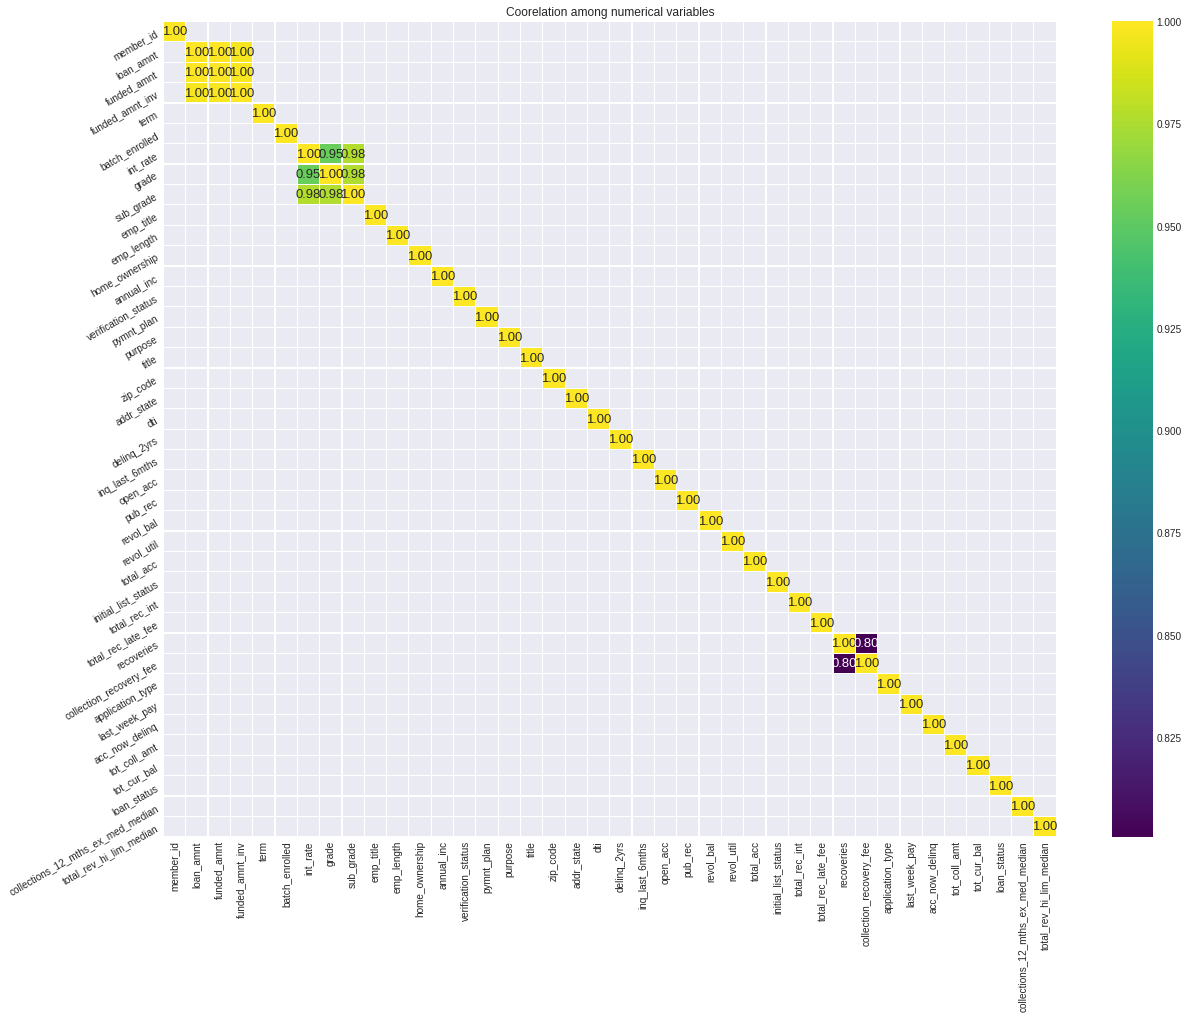

In [47]:
# Feature to feature relationship
plt.figure(figsize=(20, 15))
plt.title('Coorelation among numerical variables')
ax = sns.heatmap(corr_data_train1[(corr_data_train1 >= 0.8) | (corr_data_train1 <= -0.8)], fmt = '.2f', cmap='viridis', annot = True,
                 linewidths = 0.2, annot_kws={"size": 13})
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 30)
plt.show()

In [48]:
# remove high cooreleted features
d_train.drop(['funded_amnt', 'funded_amnt_inv', 'grade', 'sub_grade', 'collection_recovery_fee'], axis=1, inplace=True)
d_test.drop(['funded_amnt', 'funded_amnt_inv', 'grade', 'sub_grade', 'collection_recovery_fee'], axis=1, inplace=True)

# remove few other features as no importances with respect to output variable and business case study so far
d_test.drop(['member_id', 'emp_title', 'purpose', 'title', 'last_week_pay', 'zip_code', 'last_week_pay'], axis=1, inplace=True)
d_train.drop(['member_id', 'emp_title', 'purpose', 'title', 'last_week_pay', 'zip_code', 'last_week_pay'], axis=1, inplace=True)

### Feature selection based on low variances features

In [49]:
# remove constant/ low variance features
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif

var_thres = VarianceThreshold()
var_thres.fit(d_train)

print(var_thres.get_support())
print('\nSelected features :', d_train.columns[var_thres.get_support()])

# Low variance features columns
constant_variance_columns = [column for column in d_train.columns
                    if column not in d_train.columns[var_thres.get_support()]]

print('\nTotal features :', len(constant_variance_columns))
for feature in constant_variance_columns:
     print('Feature names  :', feature)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]

Selected features : Index(['loan_amnt', 'term', 'batch_enrolled', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'loan_status', 'collections_12_mths_ex_med_median', 'total_rev_hi_lim_median'], dtype='object')

Total features : 0


### Feature selection based on Chi square (categorical variables)

In [50]:
# top features rank by chiSquare
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X1 = d_train.drop(['loan_status'],axis=1)
Y1 = d_train.loan_status

In [51]:
# consideing top 20 fratures
ordered_rank_features = SelectKBest(score_func=chi2, k=20)
ordered_feature=ordered_rank_features.fit(X1,Y1)

In [52]:
dfscores=pd.DataFrame(ordered_feature.scores_,columns=["Score"])
dfcolumns=pd.DataFrame(X1.columns)
features_rank=pd.concat([dfcolumns,dfscores],axis=1)
features_rank.columns=['Features','Score']

In [53]:
features_rank.sort_values(by='Score', ascending=False).round(3)

,Features,Score
25,tot_cur_bal,650035350.40
27,total_rev_hi_lim_median,38003462.80
15,revol_bal,25340236.31
0,loan_amnt,23488874.42
21,recoveries,7530204.29
24,tot_coll_amt,5229330.02
6,annual_inc,2229678.25
19,total_rec_int,1958612.75
2,batch_enrolled,44507.46
10,dti,36898.86


### Feature selection based on mutual information gain

In [54]:
# find mutual informations 
importances_2 = mutual_info_classif(X1, Y1)
sh_imp = pd.DataFrame(importances_2, d_train.columns[0:len(d_train.columns)-1])

In [55]:
sh_imp.columns=['Score']
sh_imp.sort_values(by='Score', ascending=False)

,Score
batch_enrolled,0.11
int_rate,0.11
total_rec_int,0.07
tot_cur_bal,0.06
collections_12_mths_ex_med_median,0.06
initial_list_status,0.05
verification_status,0.03
home_ownership,0.03
term,0.02
inq_last_6mths,0.01


### Feature selection based on tree based model (RF)

In [56]:
# Feature selections by Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model_RF_trial_selection = RandomForestClassifier(random_state = 256)
model_RF_trial_selection.fit(X1, Y1)

scores_RF_trial_selection = model_RF_trial_selection.feature_importances_.round(5)
best_features_RF_trial = pd.DataFrame({'Features' : X1, 'Importances' : scores_RF_trial_selection})

In [57]:
best_features_RF_trial.sort_values('Importances', ascending = False)

,Features,Importances
25,"(t, o, t, _, c, u, r, _, b, a, l)",0.15
27,"(t, o, t, a, l, _, r, e, v, _, h, i, _, l, i, ...",0.08
19,"(t, o, t, a, l, _, r, e, c, _, i, n, t)",0.08
2,"(b, a, t, c, h, _, e, n, r, o, l, l, e, d)",0.07
10,"(d, t, i)",0.06
3,"(i, n, t, _, r, a, t, e)",0.06
15,"(r, e, v, o, l, _, b, a, l)",0.06
16,"(r, e, v, o, l, _, u, t, i, l)",0.05
0,"(l, o, a, n, _, a, m, n, t)",0.05
6,"(a, n, n, u, a, l, _, i, n, c)",0.05


- After analyzing all the selection methods, the features that are commonly given less importances are consider for removal.
- Prior to that, few features are also consider with business requirement. But here, no more such aspect considered.
- Below are the fetures that we are going to remove from the dataset for models.

In [58]:
# remove the least features gven importances to top 20
print('before importances (train):', d_train.shape)
d_train.drop(['delinq_2yrs', 'addr_state', 'pub_rec', 'emp_length', 'collections_12_mths_ex_med_median',
               'total_rec_late_fee', 'verification_status', 'acc_now_delinq', 'application_type', 'total_acc', 
               'home_ownership', 'int_rate', 'pymnt_plan'], axis=1, inplace=True)

print('before importances (test):', d_test.shape)
d_test.drop(['delinq_2yrs', 'addr_state', 'pub_rec', 'emp_length', 'collections_12_mths_ex_med_median',
               'total_rec_late_fee', 'verification_status', 'acc_now_delinq', 'application_type', 'total_acc', 
               'home_ownership', 'int_rate', 'pymnt_plan'], axis=1, inplace=True)

print('aftwe importances (train):', d_train.shape)
print('aftwe importances (test):', d_test.shape)

before importances (train): (532412, 29)
before importances (test): (354938, 28)
aftwe importances (train): (532412, 16)
aftwe importances (test): (354938, 15)


In [59]:
d_test.keys()

Index(['loan_amnt', 'term', 'batch_enrolled', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'initial_list_status', 'total_rec_int', 'recoveries', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim_median'], dtype='object')

- Below are the featrues that are considerable for model and business case,
- __'loan_amnt', 'term', 'batch_enrolled', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'initial_list_status', 'total_rec_int', 'recoveries', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim_median', 'loan_status'__

### D-3) Feature Scaling

In [60]:
# scaling the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# on training set
d_train['loan_amnt'] = sc.fit_transform(d_train[['loan_amnt']])
d_train['term'] = sc.fit_transform(d_train[['term']])
d_train['batch_enrolled'] = sc.fit_transform(d_train[['batch_enrolled']])
d_train['annual_inc'] = sc.fit_transform(d_train[['annual_inc']])
d_train['dti'] = sc.fit_transform(d_train[['dti']])
d_train['inq_last_6mths'] = sc.fit_transform(d_train[['inq_last_6mths']])
d_train['open_acc'] = sc.fit_transform(d_train[['open_acc']])
d_train['revol_bal'] = sc.fit_transform(d_train[['revol_bal']])
d_train['revol_util'] = sc.fit_transform(d_train[['revol_util']])
d_train['initial_list_status'] = sc.fit_transform(d_train[['initial_list_status']])
d_train['total_rec_int'] = sc.fit_transform(d_train[['total_rec_int']])
d_train['recoveries'] = sc.fit_transform(d_train[['recoveries']])
d_train['tot_coll_amt'] = sc.fit_transform(d_train[['tot_coll_amt']])
d_train['tot_cur_bal'] = sc.fit_transform(d_train[['tot_cur_bal']])
d_train['total_rev_hi_lim_median'] = sc.fit_transform(d_train[['total_rev_hi_lim_median']])

# on vaidation set
d_test['loan_amnt'] = sc.fit_transform(d_test[['loan_amnt']])
d_test['term'] = sc.fit_transform(d_test[['term']])
d_test['batch_enrolled'] = sc.fit_transform(d_test[['batch_enrolled']])
d_test['annual_inc'] = sc.fit_transform(d_test[['annual_inc']])
d_test['dti'] = sc.fit_transform(d_test[['dti']])
d_test['inq_last_6mths'] = sc.fit_transform(d_test[['inq_last_6mths']])
d_test['open_acc'] = sc.fit_transform(d_test[['open_acc']])
d_test['revol_bal'] = sc.fit_transform(d_test[['revol_bal']])
d_test['revol_util'] = sc.fit_transform(d_test[['revol_util']])
d_test['initial_list_status'] = sc.fit_transform(d_test[['initial_list_status']])
d_test['total_rec_int'] = sc.fit_transform(d_test[['total_rec_int']])
d_test['recoveries'] = sc.fit_transform(d_test[['recoveries']])
d_test['tot_coll_amt'] = sc.fit_transform(d_test[['tot_coll_amt']])
d_test['tot_cur_bal'] = sc.fit_transform(d_test[['tot_cur_bal']])
d_test['total_rev_hi_lim_median'] = sc.fit_transform(d_test[['total_rev_hi_lim_median']])

In [61]:
d_train.head()

,loan_amnt,term,batch_enrolled,annual_inc,dti,inq_last_6mths,open_acc,revol_bal,revol_util,initial_list_status,total_rec_int,recoveries,tot_coll_amt,tot_cur_bal,loan_status,total_rev_hi_lim_median
0,-0.05,-0.65,1.04,-0.71,1.88,0.31,0.46,0.25,0.76,-0.97,-0.28,-0.11,-0.10,-0.66,0,-0.02
1,-1.18,-0.65,-1.49,-0.15,-1.73,0.31,-1.04,-0.41,-1.33,1.03,-0.80,-0.11,-0.10,-0.78,0,0.04
2,-0.56,-0.65,-1.49,-0.46,0.03,-0.70,-1.23,-0.27,-1.00,1.03,-0.81,-0.11,-0.07,-0.59,0,0.10
3,0.03,-0.65,0.40,0.46,-0.38,1.31,-0.29,-0.14,0.02,-0.97,1.48,-0.11,-0.10,-0.48,0,-0.18
4,0.15,-0.65,-0.80,-0.35,0.24,-0.70,-0.10,0.84,0.89,1.03,0.26,-0.11,-0.10,-0.53,0,0.43


In [62]:
d_test.head()

,loan_amnt,term,batch_enrolled,annual_inc,dti,inq_last_6mths,open_acc,revol_bal,revol_util,initial_list_status,total_rec_int,recoveries,tot_coll_amt,tot_cur_bal,total_rev_hi_lim_median
0,-0.09,1.53,-0.89,-0.02,0.42,0.31,0.83,0.58,0.43,-0.97,1.03,-0.11,-0.01,-0.28,0.41
1,0.15,1.53,-1.19,0.47,0.52,-0.69,-0.67,-0.57,-1.50,1.03,-0.12,-0.11,-0.01,2.08,-0.28
2,-0.44,1.53,-1.07,-0.20,0.14,-0.69,-0.10,-0.22,0.79,1.03,0.16,-0.11,-0.01,-0.15,-0.43
3,2.40,1.53,-0.92,1.17,-0.04,-0.69,1.77,0.70,-0.42,-0.97,-0.00,-0.11,-0.01,1.04,1.16
4,-0.98,-0.66,0.81,-0.36,0.08,-0.69,0.83,-0.53,-1.50,1.03,-0.76,-0.11,-0.01,0.70,-0.13


In [63]:
# saving the processed files
d_train.to_csv('drive/MyDrive/dataset_mumbai/d_train.csv', index=False)
d_test.to_csv('drive/MyDrive/dataset_mumbai/d_test.csv', index=False)

## E) Spliting dataset and Balancing

In [64]:
d_train = pd.read_csv('drive/MyDrive/dataset_mumbai/d_train.csv')
d_test = pd.read_csv('drive/MyDrive/dataset_mumbai/d_test.csv')

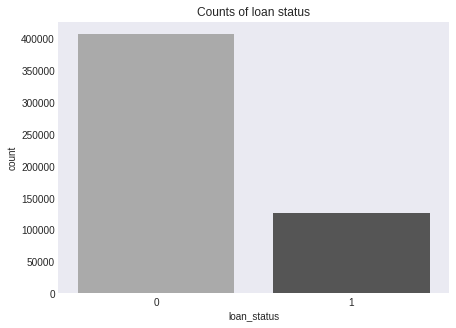

In [65]:
plt.subplots(figsize=(7, 5))
sns.countplot(x = d_train.loan_status, palette = 'gist_gray_r')
plt.title('Counts of loan status')
plt.show()

In [66]:
train_dataset = d_train.copy()
test_dataset = d_test.copy()

In [67]:
# separating the feature and the Label columns 
X = train_dataset.drop(labels='loan_status', axis=1).values
y = train_dataset['loan_status'].values

In [68]:
# majority class and minority class seperations
data_minority = train_dataset.loc[train_dataset['loan_status']==1]
data_majority = train_dataset.loc[train_dataset['loan_status']==0]

In [69]:
print(data_minority.shape)
print(data_majority.shape)

(125814, 16)
(406598, 16)


In [70]:
# take out 87% of majority class
406598*0.87

353740.26

- Minority class has records = __125814__
- Majority class has records = __406598__
- So, we need to upsample the minority class datapoints to majority class datapoints.
- Here, we are not doing downsapling as data loss has the major issue with it. Oversampling has many techniques like SMOTE, ADASYN, etc. 
- Selected the upsample method from resample library as we have decide how many datapoints need to be added for balancing one.
-  We are going to add __87%__ datapoints (353740) to minority class.

In [71]:
from sklearn.utils import resample
from sklearn.utils import shuffle

data_minority_upsampled = resample(data_minority, replace=True, n_samples=353740, random_state=42)  
data_upsampled = pd.concat([data_majority, data_minority_upsampled], ignore_index=True)

data_upsampled = shuffle(data_upsampled)
print(data_upsampled.shape)
data_upsampled.loan_status.value_counts()

(760338, 16)


0    406598
1    353740
Name: loan_status, dtype: int64

In [72]:
# seperation of dependenet and independent features
X = data_upsampled.drop(['loan_status'],axis=1).values
Y = data_upsampled.loan_status.values

In [73]:
# spliting into train and test segments
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, stratify=Y, test_size=0.25, random_state=101)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((570253, 15), (190085, 15), (570253,), (190085,))

## F) Model Building

### F-1) Model I - RandomForestClassifier

In [74]:
from sklearn.ensemble import RandomForestClassifier
m1 = RandomForestClassifier()
m1.fit(train_x, train_y)  

predd_y1 = m1.predict(train_x)
pred_y1 = m1.predict(test_x)

print('ROC-AUC score          :', roc_auc_score(test_y, pred_y1))
print('\nAccuracy score (train) :', accuracy_score(train_y, predd_y1))
print('\nAccuracy score (test)  :', accuracy_score(test_y, pred_y1))
print('\nF1 score               :', f1_score(test_y, pred_y1))
print('\nConfusion matrix :\n', confusion_matrix(test_y, pred_y1))
print('\nclassification report :\n', classification_report(test_y, pred_y1))

ROC-AUC score          : 0.9442716801652699

Accuracy score (train) : 0.9999982463923908

Accuracy score (test)  : 0.9450772023042323

F1 score               : 0.940480262707806

Confusion matrix :
 [[97163  4487]
 [ 5953 82482]]

classification report :
               precision    recall  f1-score   support

           0       0.94      0.96      0.95    101650
           1       0.95      0.93      0.94     88435

    accuracy                           0.95    190085
   macro avg       0.95      0.94      0.94    190085
weighted avg       0.95      0.95      0.95    190085



### F-2) Model II - XGBoostClassifier

In [75]:
from xgboost import XGBClassifier
m3 = XGBClassifier()
m3.fit(train_x, train_y)  

predd_y3 = m3.predict(train_x)
pred_y3 = m3.predict(test_x)

print('ROC-AUC score          :', roc_auc_score(test_y, pred_y3))
print('\nAccuracy score (train) :', accuracy_score(train_y, predd_y3))
print('\nAccuracy score (test)  :', accuracy_score(test_y, pred_y3))
print('\nF1 score               :', f1_score(test_y, pred_y3))
print('\nConfusion matrix :\n', confusion_matrix(test_y, pred_y3))
print('\nclassification report :\n', classification_report(test_y, pred_y3))

ROC-AUC score          : 0.7175409130363312

Accuracy score (train) : 0.7278015196763542

Accuracy score (test)  : 0.7258752663282216

F1 score               : 0.6698222602414219

Confusion matrix :
 [[85124 16526]
 [35581 52854]]

classification report :
               precision    recall  f1-score   support

           0       0.71      0.84      0.77    101650
           1       0.76      0.60      0.67     88435

    accuracy                           0.73    190085
   macro avg       0.73      0.72      0.72    190085
weighted avg       0.73      0.73      0.72    190085



### F-3) Model III - LightBGM

In [78]:
import lightgbm as lgb
m2 = lgb.LGBMClassifier()
m2.fit(train_x, train_y)

predd_y2 = m2.predict(train_x)
pred_y2 = m2.predict(test_x)

print('ROC-AUC score          :', roc_auc_score(test_y, pred_y2))
print('\nAccuracy score (train) :', accuracy_score(train_y, predd_y2))
print('\nAccuracy score (test)  :', accuracy_score(test_y, pred_y2))
print('\nF1 score               :', f1_score(test_y, pred_y2))
print('\nConfusion matrix :\n', confusion_matrix(test_y, pred_y2))
print('\nclassification report :\n', classification_report(test_y, pred_y2))

ROC-AUC score          : 0.7757987760108268

Accuracy score (train) : 0.7823930781600448

Accuracy score (test)  : 0.7803298524344372

F1 score               : 0.7506270753207042

Confusion matrix :
 [[85485 16165]
 [25591 62844]]

classification report :
               precision    recall  f1-score   support

           0       0.77      0.84      0.80    101650
           1       0.80      0.71      0.75     88435

    accuracy                           0.78    190085
   macro avg       0.78      0.78      0.78    190085
weighted avg       0.78      0.78      0.78    190085



## G) Model Evaluations

In [79]:
# checking the overfiiting (RandomForestClassifier)
print('Training set score: {:.4f}'.format(m1.score(train_x, train_y)))
print('Testset score: {:.4f}'.format(m1.score(test_x, test_y)))

Training set score: 1.0000
Testset score: 0.9451


- The training and test set accuracy are quite comparable. So, we cannot say there is overfitting

### G-1) Classification report

In [80]:
# Classification report
print(classification_report(test_y, pred_y1))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95    101650
           1       0.95      0.93      0.94     88435

    accuracy                           0.95    190085
   macro avg       0.95      0.94      0.94    190085
weighted avg       0.95      0.95      0.95    190085



### G-2) Confusion matrics

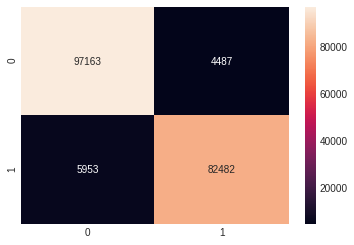

In [81]:
sns.heatmap(confusion_matrix(test_y, pred_y1), annot=True, fmt='.7g' )
plt.show()

### G-3) Cross Validations - StratifiedKFold CV

In [82]:
X1 = data_upsampled.drop(['loan_status'],axis=1).values
Y1 = data_upsampled.loan_status.values

In [83]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=256) 

lst_accu_stratified = [] 

for train_index, test_index in skf.split(X1, Y1): 
    print('train:', train_index, 'validation: ', test_index)
    x_train_fold, x_test_fold = X1[train_index], X1[test_index] 
    y_train_fold, y_test_fold = Y1[train_index], Y1[test_index] 
    
    m1.fit(x_train_fold, y_train_fold) 

    lst_accu_stratified.append(m1.score(x_test_fold, y_test_fold)) 

print("-------------------------------------------------------------------")

print('List of possible accuracy:', lst_accu_stratified) 
print('\nMaximum Accuracy That can be obtained from this model is:', 
      max(lst_accu_stratified)*100, '%') 
print('\nMinimum Accuracy:', 
      min(lst_accu_stratified)*100, '%') 
print('\nOverall Accuracy:', 
      np.mean(lst_accu_stratified)*100, '%') 
print('\nStandard Deviation is:', np.std(lst_accu_stratified))

train: [     0      1      3 ... 760334 760335 760337] validation:  [     2      4      6 ... 760325 760327 760336]
train: [     1      2      3 ... 760335 760336 760337] validation:  [     0      5     12 ... 760328 760329 760332]
train: [     0      2      4 ... 760333 760334 760336] validation:  [     1      3      7 ... 760326 760335 760337]
train: [     0      1      2 ... 760335 760336 760337] validation:  [     8     11     13 ... 760323 760331 760333]
train: [     0      1      2 ... 760335 760336 760337] validation:  [    23     27     34 ... 760320 760330 760334]
-------------------------------------------------------------------
List of possible accuracy: [0.9508969671462767, 0.9512915274745508, 0.9507194149985533, 0.9494367614275286, 0.9498313243504508]

Maximum Accuracy That can be obtained from this model is: 95.12915274745508 %

Minimum Accuracy: 94.94367614275286 %

Overall Accuracy: 95.0435199079472 %

Standard Deviation is: 0.0006912089683397631
CPU times: user 21min 

### G-4) ROC-AUC Score

In [84]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, pred_y1)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('The ROC score :', round(roc_auc, 5)*100)

The ROC score : 94.427


Text(0.5, 0, 'False Positive Rate')

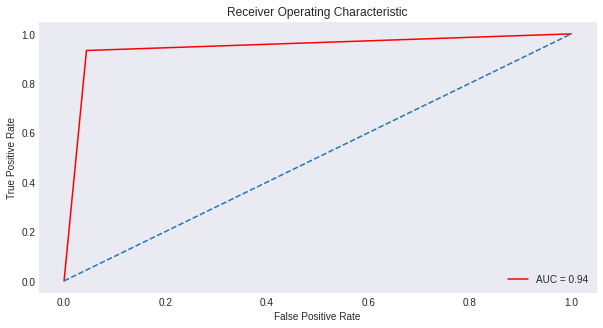

In [85]:
# ROC curve
plt.figure(figsize=(10,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## H) Predictions and Submission on validation set

In [86]:
# load validation data
final_test_data = np.array(test_dataset)

In [87]:
# predition on validation set
final = pd.Series(m1.predict(final_test_data))
print(len(final))
final.value_counts()

354938


0    258604
1     96334
dtype: int64

In [88]:
# submission file
submission_1 = pd.read_csv('drive/MyDrive/dataset_mumbai/sample_submission.csv')

submission_1['loan_status'] = final
submission_1['member_id'] = data_test['member_id']

submission_1.head()

,member_id,loan_status
0,11937648,0
1,38983318,0
2,27999917,0
3,61514932,0
4,59622821,0


In [89]:
submission_1.to_csv("drive/MyDrive/dataset_mumbai/output/sample_submission.csv", index=False, encoding="utf-8")
submission_1.loan_status.value_counts()

0    77
1    23
Name: loan_status, dtype: int64